<a href="https://colab.research.google.com/github/EngBaz/Generative-AI-GANs/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [2]:
print(device)

cpu


In [3]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, num_channels):
        super(Generator, self).__init__()
        self.cnn1 = nn.ConvTranspose2d(input_size, hidden_size*4, kernel_size=4, stride=1, padding=0, bias=False)
        self.norm1 = nn.BatchNorm2d(hidden_size*4)
        self.cnn2 = nn.ConvTranspose2d(hidden_size*4, hidden_size*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.norm2 = nn.BatchNorm2d(hidden_size*2)
        self.cnn3 = nn.ConvTranspose2d(hidden_size*2, hidden_size, kernel_size=4, stride=2, padding=1, bias=False)
        self.norm3 = nn.BatchNorm2d(hidden_size)
        self.cnn4 = nn.ConvTranspose2d(hidden_size, num_channels, kernel_size=4, stride=2, padding=3, bias=False)
        
    def forward(self, x):
        x = F.relu(self.norm1(self.cnn1(x)))
        x = F.relu(self.norm2(self.cnn2(x)))
        x = F.relu(self.norm3(self.cnn3(x)))
        x = F.tanh(self.cnn4(x))
        
        return x

In [4]:
class Discriminator(nn.Module):
    def __init__(self, num_channels, hidden_size):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, hidden_size, kernel_size=4, stride=2, padding=3, bias=False)
        self.relu1 = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(hidden_size, hidden_size*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.norm2 = nn.BatchNorm2d(hidden_size*2)
        self.relu2 = nn.LeakyReLU(0.2)
        self.conv3 = nn.Conv2d(hidden_size*2, hidden_size*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.norm3 = nn.BatchNorm2d(hidden_size*4)
        self.relu3 = nn.LeakyReLU(0.2)
        self.conv4 = nn.Conv2d(hidden_size*4, num_channels, kernel_size=4, stride=1, padding=0, bias=False)
            
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.norm2(self.conv2(x)))
        x = self.relu3(self.norm3(self.conv3(x)))
        x = F.sigmoid(self.conv4(x))
        return x

In [5]:
def weight_init(module):
    classname = module.__class__.__name__
    if classname.find('Conv')!=-1:
        module.weight.data.normal_(0.0, .02)
    elif classname.find('BatchNorm') != -1:
        module.weight.data.normal_(1.0, .01)
        module.bias.data.fill_(0.0)

In [6]:
def plot(epoch, batch_idx, d_losses, g_losses):
    clear_output(True)
    plt.title('epoch %s. | batch: %s | d_loss: %s | g_loss: %s' % (epoch, batch_idx, round(np.mean(d_losses[-100:]),2), round(np.mean(g_losses[-100:]),2)))
    plt.plot(d_losses, label='discriminator loss')
    plt.plot(g_losses, label='generator loss')
    plt.legend()
    plt.show()

In [7]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

In [8]:
batch_size = 16
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 143477819.53it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 104337376.25it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32442775.77it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19281911.71it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [9]:
input_size = 100
hidden_size = 64  #Size of feature maps
num_channels = 1  #Num of channels
g_model = Generator(input_size, hidden_size, num_channels)
g_model = g_model.to(device)

In [10]:
d_model = Discriminator(num_channels, hidden_size)
d_model = d_model.to(device)

In [11]:
g_model.apply(weight_init)
d_model.apply(weight_init)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
  (relu1): LeakyReLU(negative_slope=0.2)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (conv4): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

In [12]:
lr = 2e-4
g_optimizer = optim.SGD(g_model.parameters(), lr=lr)
d_optimizer = optim.SGD(d_model.parameters(), lr=lr)

In [13]:
criterion = nn.BCELoss()

In [14]:
g_losses = []
d_losses = []

In [15]:
steps = len(train_dataloader)*batch_size

In [16]:
import os
output_dir = 'results/dcgan_bs16_ls100_lr2e-4'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

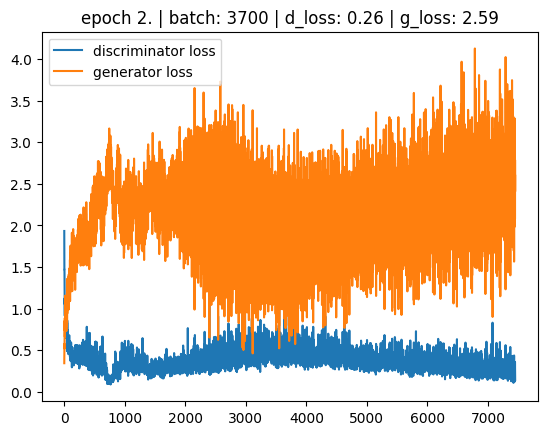

In [17]:
epochs = 2
for epoch in range(1, epochs+1):
    for batch_idx, data in enumerate(train_dataloader):
        x = data[0].to(device)
        real_y = torch.ones(x.shape[0], 1, 1, 1).to(device)
        fake_y = torch.zeros(x.shape[0], 1, 1, 1).to(device)
        noise = torch.randn(x.shape[0], input_size, 1, 1).to(device)
        
        #Train Generator
        g_out = g_model(noise)
        d_out = d_model(g_out)
        g_loss = criterion(d_out, real_y)
        g_losses.append(g_loss.item())
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        #Train Discriminator
        real_out = d_model(x)
        real_loss = criterion(real_out, real_y)
        fake_out = d_model(g_out.detach())
        fake_loss = criterion(fake_out, fake_y)
        d_loss = real_loss + fake_loss
        d_losses.append(d_loss.item())
        
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        if batch_idx != 0 and batch_idx % 100 == 0:
            plot(epoch, batch_idx, d_losses, g_losses)

    if epoch%50==0:
        torch.save(g_model, os.path.join(output_dir, 'generator_epoch%s.pt'%epoch))